# ECE 351 - Final Project
## Introduction
The purpose of this lab is to apply all of this semester's cumulative skills and concepts to a more in-depth and practical problem. The problem I'll be tackling in this lab is filter noise from 'sensor' data, and extract only the meaningful information produced by the sensor. To do this, I'll be parsing the input data, designing a filter to pass the analog signal of the sensor _through_, and then analyzing the output of the data through the sensor. The project states specific requirements for the filter as well as the analysis, so my design will also meet those specifications.

In [1]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack
import control
from pandas import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [11]:
colors = ["blue", "red", "green", "purple", "gray", "orange"]
# Generic Function to create a plot
def create_plot(x, y, xLabel=["X-Values"], yLabel=["Y-Values"],
                title=["Plot"], mode_list=["Norm"], num_rows=1, size=(16, 12)):
    plt.figure(figsize=size, dpi=350)
    for c, (x_vals, y_vals, x_labels, y_labels, titles, mode) in enumerate(
        zip(x, y, xLabel, yLabel, title, mode_list)):
        for c2, (y_v, t) in enumerate(zip(y_vals, titles)):
            plt.subplot(num_rows, 1, c + 1)
            # Add a plot to the subplot, use transparency so they can both be seen
            if mode is "Norm":
                plt.plot(x_vals, y_v, label=t, color=colors[c2+c], alpha=0.70)
            elif mode is "Log":
                plt.semilogx(x_vals, y_v, label=t, color=colors[c2+c], alpha=0.70)
            elif mode is "Stem":
#                 for c3, y in enumerate(np.real(y_v)):
#                     if abs(y) > 1000:
#                         plt.text(x_vals[c3], y, str(int(x_vals[c3])) + " " + str(int(y)))
                if len(x_vals) < 500:
                    plt.stem(x_vals, y_v, label=t)
                else:
                    plt.axhline(x_vals[0], x_vals[-1], 0, color=colors[c2+c])
                    plt.vlines(x_vals, 0, y_v, color=colors[c2+c], linestyles='solid', label=t, linewidths=1.75)
            plt.ylabel(y_labels)
            plt.xlabel(x_labels)
            plt.grid(True)
            plt.legend(loc='upper right')
    
    plt.show()
    
# My own version of the FFT algorithm for some function in the time domain
def fast_fourier(x_func, sample_freq):
    x_mag = scipy.fftpack.fft(x_func) # FFT of x(t)    
    freq  = scipy.fftpack.fftfreq(x_mag.shape[-1], 1 / sample_freq)
    x_phi = np.angle(x_mag) # Phase of the signal
    xPhi = [0 if abs(mag) < 1e-10 else xp for xp, mag in zip(x_phi, x_mag)]
    
    return (freq, x_mag, x_phi)

# Return a changed time array for a set sample frequency and end time
def adjust_time(sample_freq, t_end):
    return (sample_freq, np.arange(0, t_end, 1 / sample_freq))

# Generic function to subdivide the response on various frequency bounds
def subdivide_freq_mag(freq_sig, mag_sig, freq_bounds=[0, 10], mode="Log"):
    sub_freq, sub_mag = [], []
    for freq_val, mag_val in zip(freq_sig, mag_sig):
        if freq_val >= freq_bounds[0] and freq_val <= freq_bounds[1]:
            sub_freq.append(freq_val)
            if mode is "Log":
                sub_mag.append(20 * np.log10(mag_val))
            else:
                sub_mag.append(mag_val)
            
    return sub_freq, sub_mag

I'll be picking a sampling frequency that corresponds to the inverse of the time-increments of the input signal. This holds true to the Nyquist-Shannon theorem to sample the input at twice the highest frequency signal, and the highest possible signal frequency in the input is the time increment itself. This will allow me to look at the entire range of frequencies present in this signal.

In [3]:
# Read the data from the given CSV
df = pandas.read_csv("NoisySignal.csv")
t = df['0'].values
sensor_sig = df['1'].values

# Compute the FFT of the input signal
dt = min([t[i+1] - t[i] for i, v in enumerate(t[:-1])])
freq = 1 / dt
print ("Sampling with a frequency of {0:.1f}".format(freq))
f_samp, _ = adjust_time(sample_freq=freq, t_end=0.05)
fft_freq, x_mag, x_phi = fast_fourier(sensor_sig, f_samp)
sig_recon = scipy.fftpack.ifft(x_mag)
# Remove the negative frequency components
fft_freq, x_mag = fft_freq[:len(fft_freq)//2], x_mag[:len(x_mag)//2]

Sampling with a frequency of 1000000.0


Magnitudes of the underlying frequencies inside the noisy input signal can be shown by plotting the results of the fast fourier transform. I then compare the inverse fourier transform of this fourier series to the original signal, to visually ensure the transformation was successful.

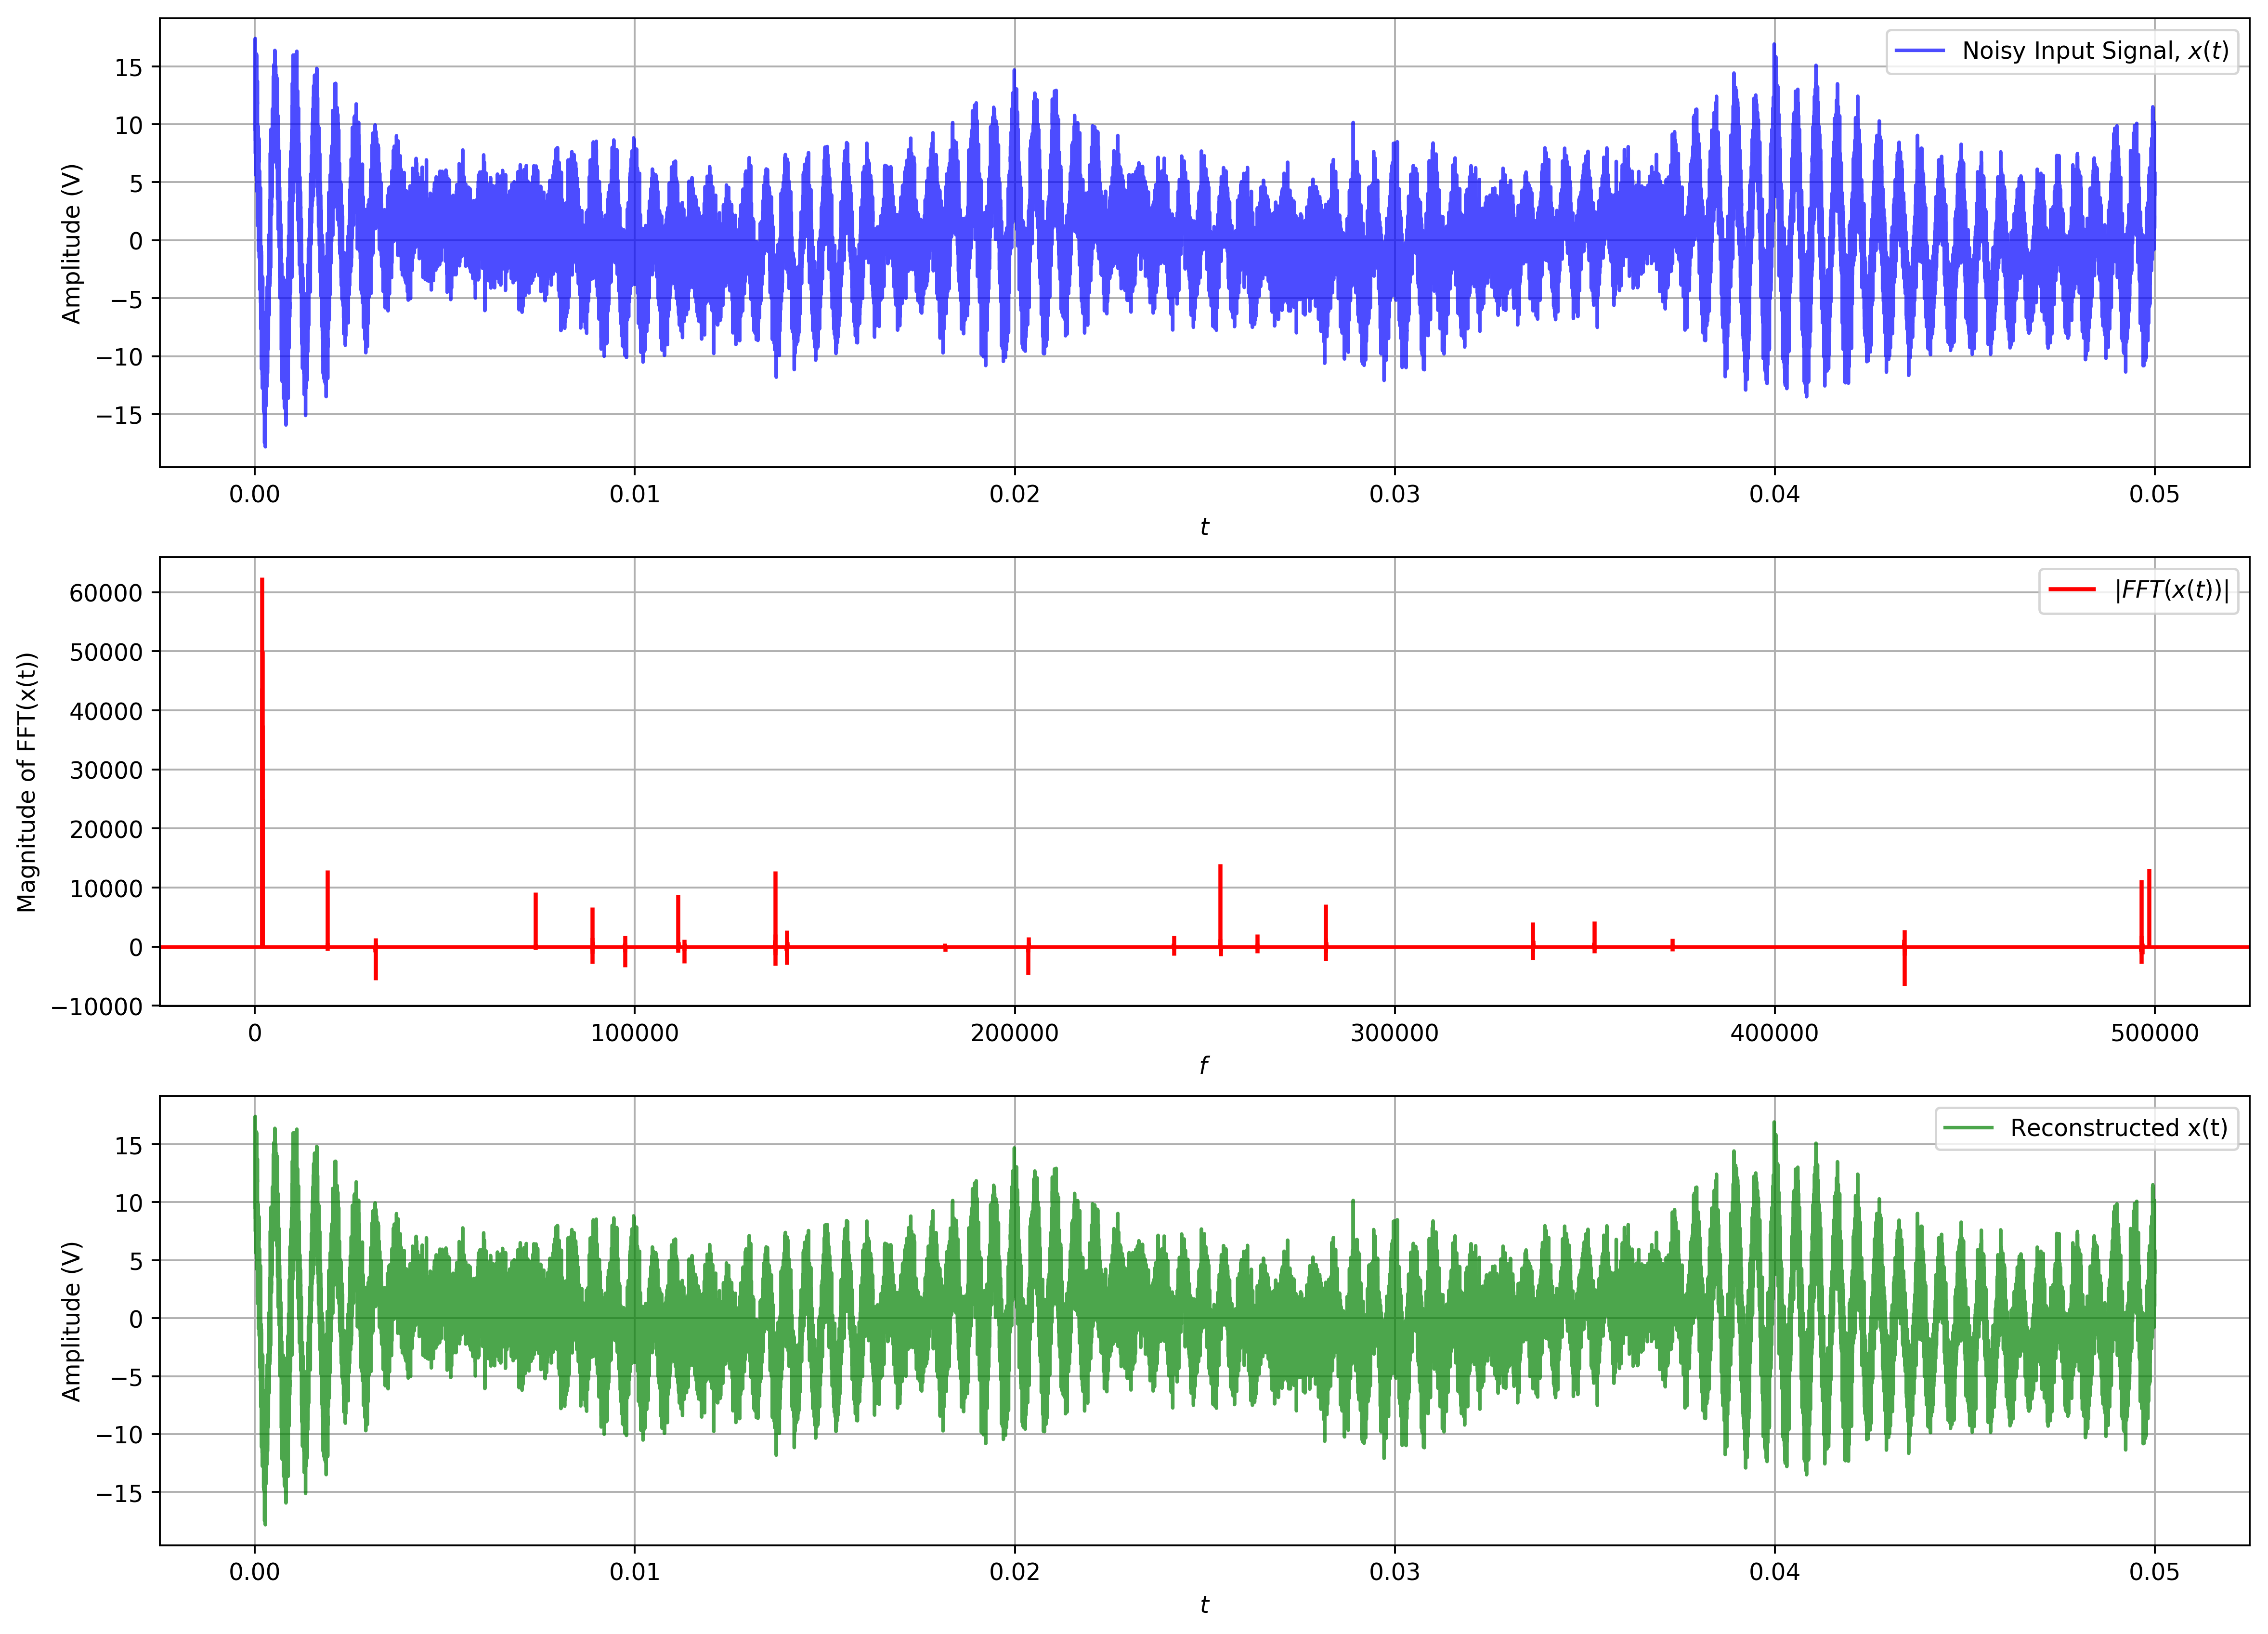

In [4]:
# Plot the above-computed data
create_plot([t, fft_freq, t],
            [(sensor_sig, ), (x_mag, ), (sig_recon, )],
            ["$t$", "$f$", "$t$"],
            ["Amplitude (V)", "Magnitude of FFT(x(t))", "Amplitude (V)"],
            [("Noisy Input Signal, $x(t)$", ), ("$|FFT(x(t))|$", ), ("Reconstructed x(t)",)],
            ["Norm", "Stem", "Norm"], 3)

### Task 1

Now, looking at the frequency that the sensor's data sheet says contains the sensor's position measurement, it can be determined if the above signal even contains any information (i.e. the fourier transform shows information in this frequency exists). For easier analysis, all frequencies whose magnitude is less than 1000 will be ignored. This is because those values are practically zero (although the FFT routine does not return 0), and this makes identifying the noise frequenices much easier.

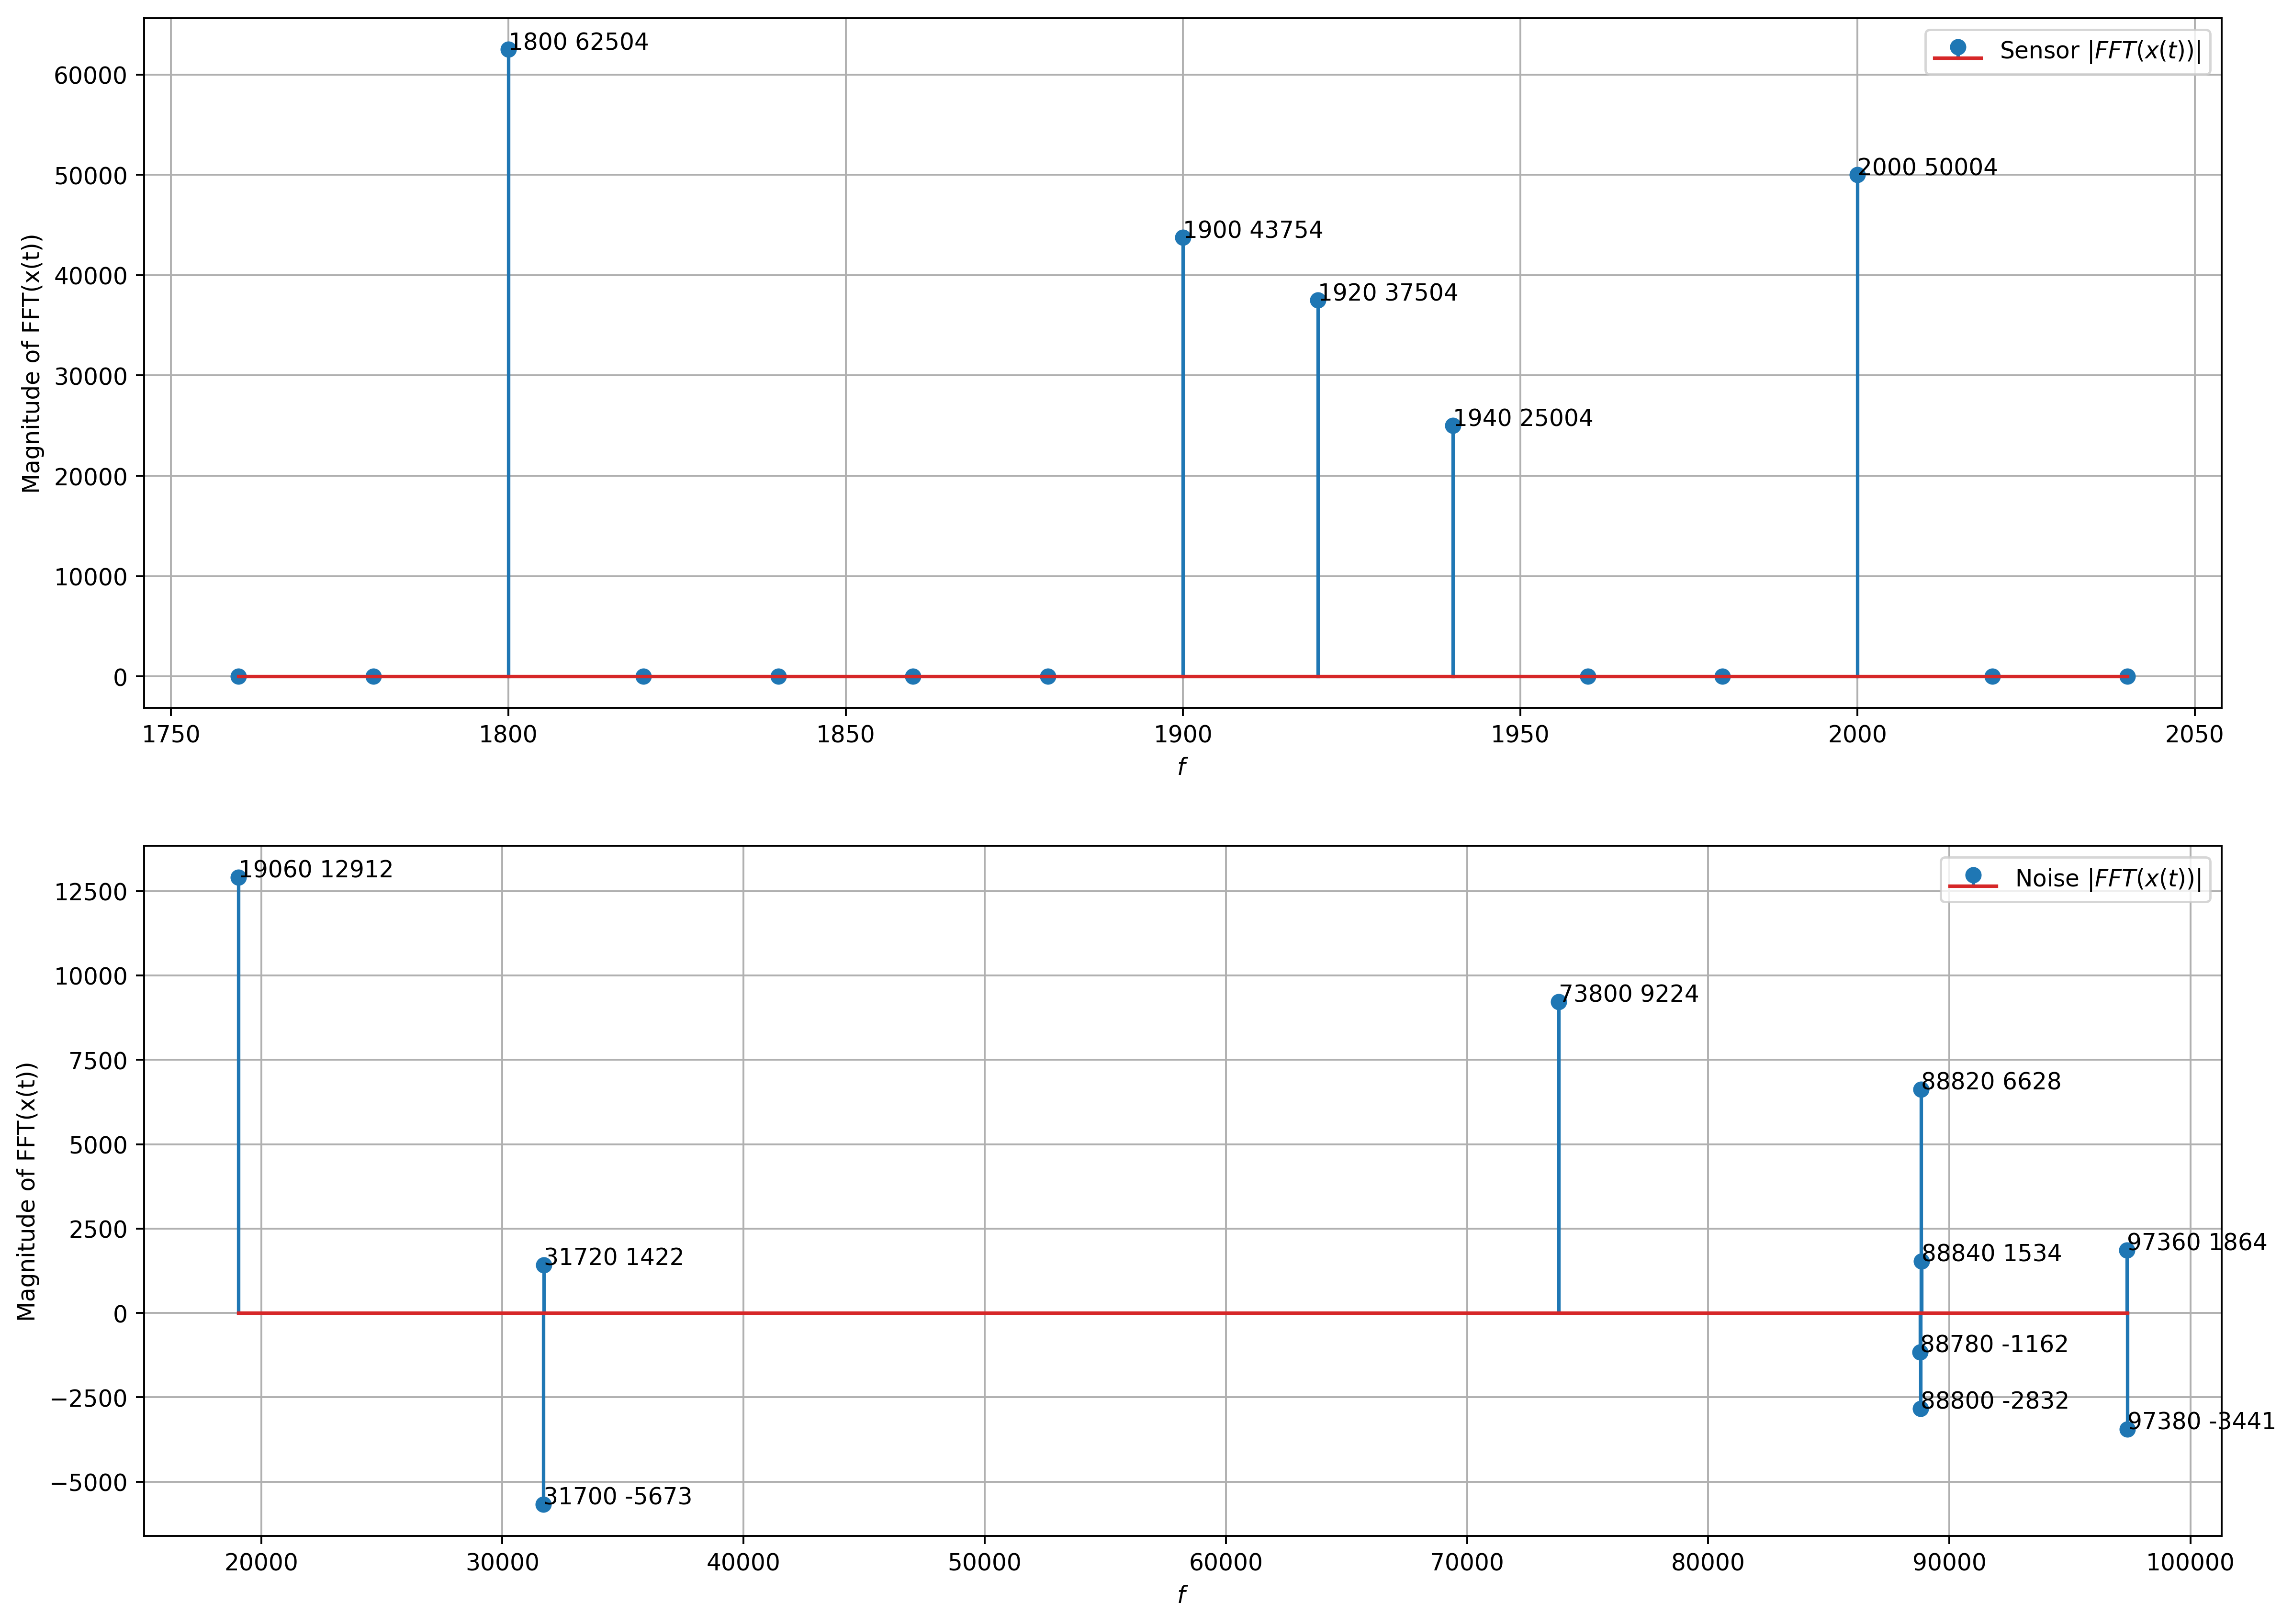

In [6]:
# Remove the very-low amplitude frequencies (less than 1000)
filt_fft_mag  = [x for x in np.real(x_mag) if abs(x) > 1000]
filt_fft_freq = [f for x, f in zip(np.real(x_mag), fft_freq) if abs(x) > 1000]

# Look at just the sensor / noise frequencies
sensor_freq, sensor_mag = subdivide_freq_mag(fft_freq, x_mag, [1750, 2050], mode="Norm")
noise_freq, noise_mag = subdivide_freq_mag(filt_fft_freq, filt_fft_mag, [2001, 100000], mode="Norm")

# Plot the sensor frequencies, and the noise frequencies
create_plot([sensor_freq, noise_freq], [(sensor_mag, ), (noise_mag, )], ["$f$", "$f$"],
            ["Magnitude of FFT(x(t))", "Magnitude of FFT(x(t))"],
            [("Sensor $|FFT(x(t))|$", ), ("Noise $|FFT(x(t))|$", )],
            mode_list=["Stem", "Stem"], num_rows=2)

Clearly, the sensor has embedded information among the stated frequencies. The highest amplitude information is actually found at these frequencies, especially 1,800, 1,900 and 2,000 Hz. This is clearly shown in the first plot. The magnitudes of these signals is shown on the graph, rather than listing them all out.

Identifying the low-frequency vibration and the switching-amplifier noise is a bit more difficult. The plot clearly shows many frequencies of signals that extend beyond the 2,000 Hz range (there are no sub-1,800 Hz signals). Because we are given no information about the expected ranges of frequencies for these noises, I'll make a judgement call that the low-frequency vibration noise is the signal at about 19,000 Hz, and the switching-amplifier noise is those at frequencies between 88 and 100 kHz. 

### Task 2

For my filtering circuit, I decided to go with a 2nd order Chebyshev bandpass filter design. I'll design it such that the cutoff frequencies for the filter will be 1700 and 1200 Hz, so that the actual attenuation at the desired frequency range of 1800 to 2000 Hz will hardly be attenuated at all. Below is the circuit design I used:

![Filter Design](Schematic.jpeg)

I started with arbitrary low values for the resistors, and then ran simulations in LTSpice sweeping the values of both capacitors and inductors. When the simulation showed reasonable attenuation for the 0 frequency range, as well as near 0.3 dB attenuation between 1800 and 2000 Hz, I used values nearer and nearer to those. This iterative process took about an hour or so, but I ended up with the values shown above.

Using this circuit, I derived the transfer function using the following formula:

$$\frac{V_{in}-V_{out}}{R_1 + \frac{1}{sC_1}+sL_1}=\frac{V_{out}}{\frac{1}{sC_2}}+\frac{V_{out}}{sL_2}+\frac{V_{out}}{R_2}$$

Solving for $V_{out}$...

$$V_{out}=\frac{s^2C_1L_2R_2V_{in}}{s^4C_1C_2L_1L_2R_2+s^3(C_1C_2L_2R_1R_2+C_1L_1L_2)+s^2(C_1L_1R_2+C_1L_2R_1+C_1L_2R_2+C_2L_2R_2)+s(L_2+C_1R_1R_2)+R_2}$$

$$H(s)=\frac{s^2C_1L_2R_2}{s^4C_1C_2L_1L_2R_2+s^3(C_1C_2L_2R_1R_2+C_1L_1L_2)+s^2(C_1L_1R_2+C_1L_2R_1+C_1L_2R_2+C_2L_2R_2)+s(L_2+C_1R_1R_2)+R_2}$$

### Task 3

This transfer function's Bode plot can be plotted as follows:

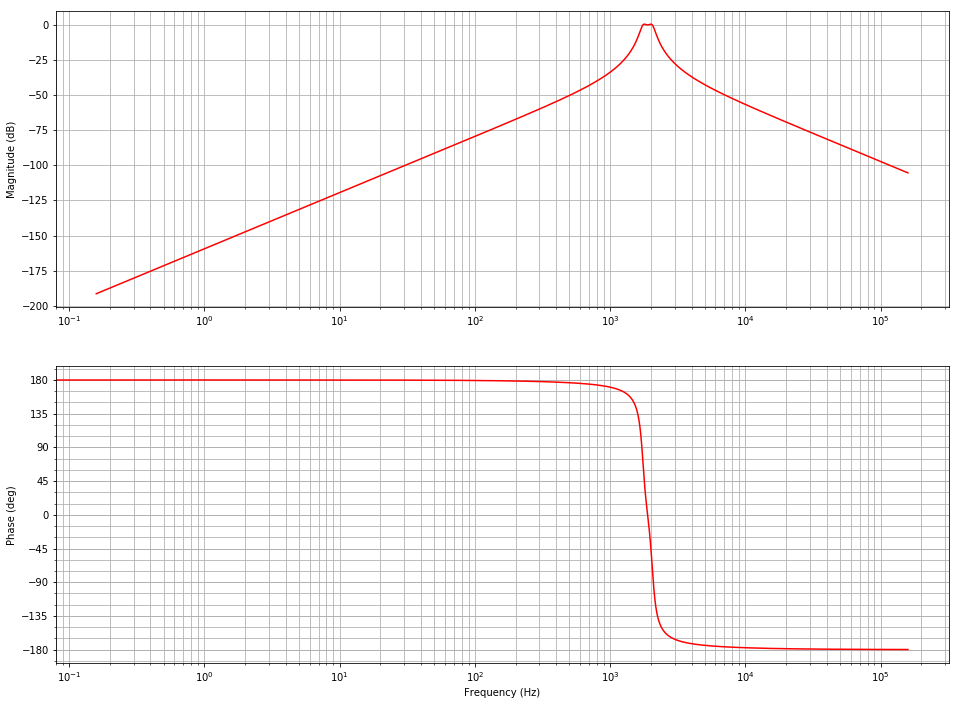

In [7]:
c1, c2 = 2.831e-6, 74.43e-6
l1, l2 = 2.494e-3, 94.87e-6
r1, r2 = 0, 5

num = [c1*l2*r2, 0, 0]
den = [c1*c2*l1*l2*r2, c1*c2*l2*r1*r2+c1*l1*l2,
       c1*l1*r2+c1*l2*r1+c1*l2*r2+c2*l2*r2, l2+c1*r1*r2, r2]
w = np.arange(0, 1e6 + 1, 1)     # Frequency in rad/s
f = [v / (2 * np.pi) for v in w] # Frequency in Hz

plt.figure(figsize=(16, 12))
system = control.TransferFunction(num, den)
m, p, o = control.bode(system, w, dB=True, Hz=True, Plot=True, deg=True, color='r')

To verify the filter specifications, because I cannot change the above Bode-plot, I'll take a look at the provided frequency ranges, and look at the magnitude of the filter's response over those ranges of frequencies. This is all shown below, as well as plots of the filter's response to those frequencies.

In [8]:
pos_f, pos_m = subdivide_freq_mag(f, m, [1750, 2050])
print ("The signal is at most attenuated by %f dB." % min(pos_m))

lowf_vib_f, lowf_vib_m = subdivide_freq_mag(f, m, [15000, 30000])
print ("The low-frequency vibration noise is attenuated by at least %f dB."
       % max(lowf_vib_m))

switch_f, switch_m = subdivide_freq_mag(f, m, [75000, 100000])
print ("The switching-amplifier noise is attenuated by at least %f dB."
       % max(switch_m))

highf_noise_f, highf_noise_m = subdivide_freq_mag(f, m, [100000, max(f)])
print ("All noises higher than 100 kHz are attenuated by at least %f dB."
       % max(highf_noise_m))

The signal is at most attenuated by -0.000001 dB.
The low-frequency vibration noise is attenuated by at least -64.062774 dB.
The switching-amplifier noise is attenuated by at least -92.291386 dB.
All noises higher than 100 kHz are attenuated by at least -97.293825 dB.


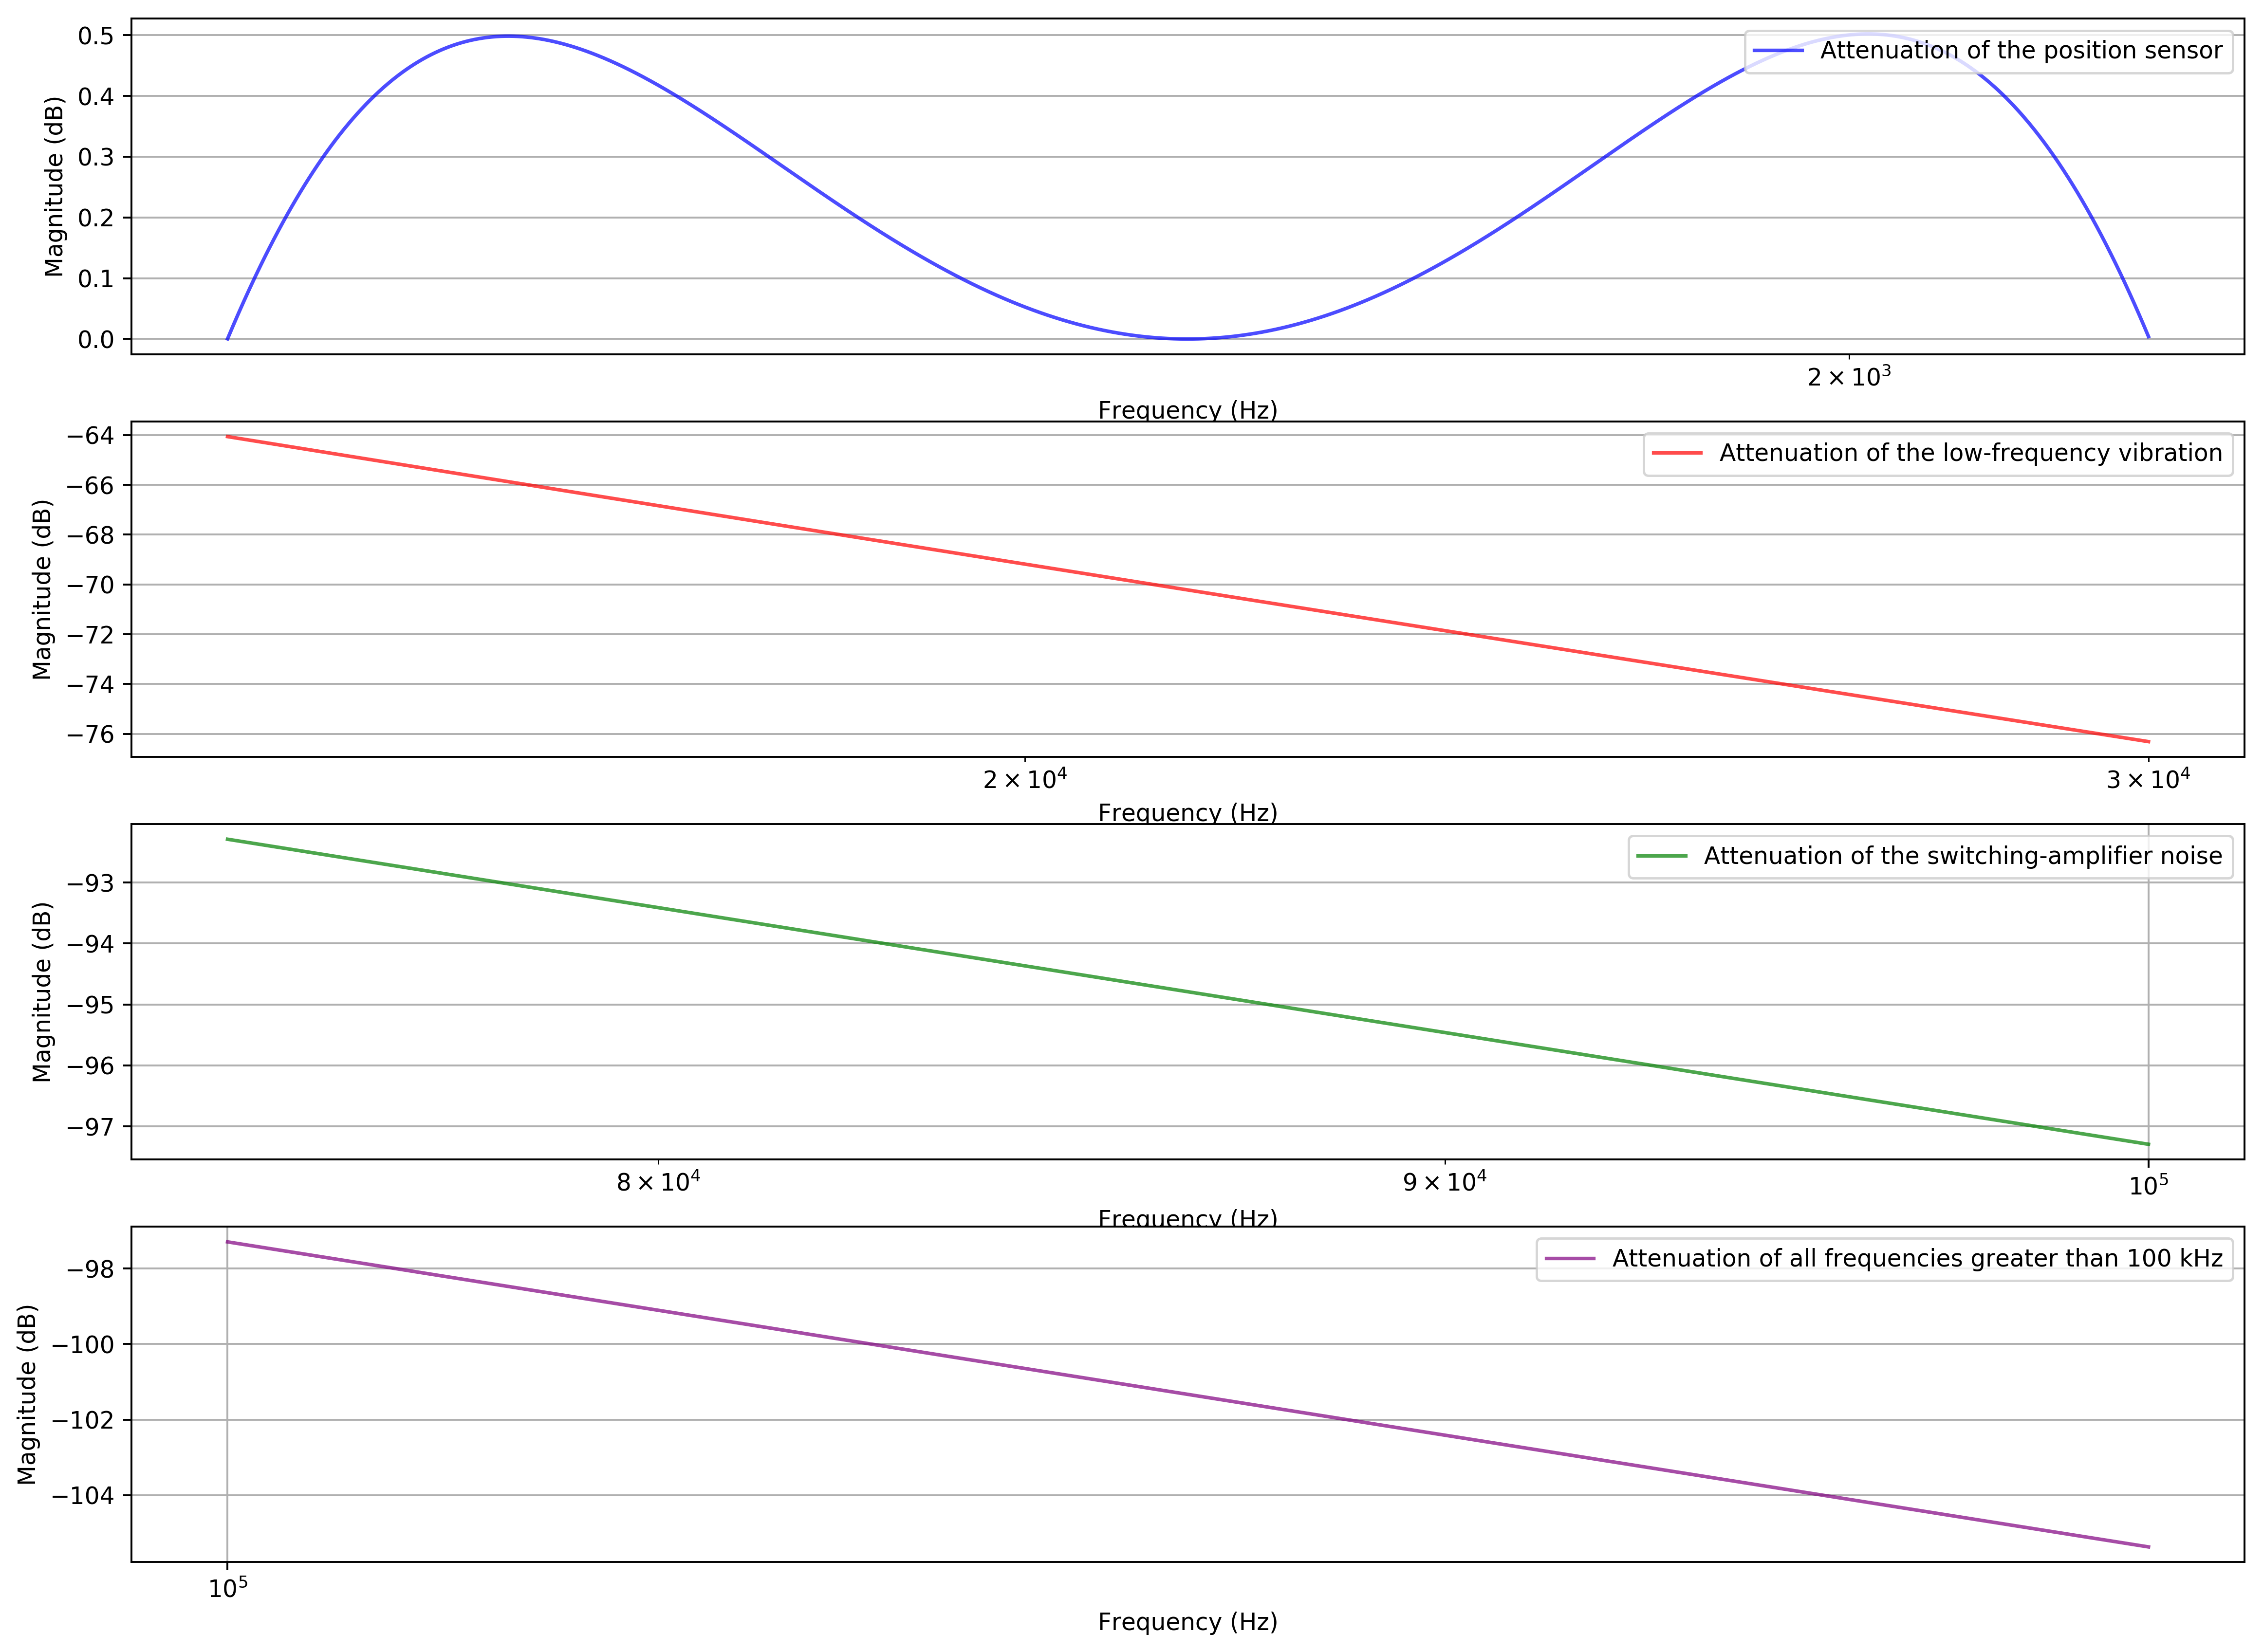

In [9]:
create_plot([pos_f, lowf_vib_f, switch_f, highf_noise_f],
            [(pos_m, ), (lowf_vib_m, ), (switch_m, ), (highf_noise_m, )],
            ["Frequency (Hz)", "Frequency (Hz)", "Frequency (Hz)", "Frequency (Hz)"],
            ["Magnitude (dB)", "Magnitude (dB)", "Magnitude (dB)", "Magnitude (dB)"],
            [("Attenuation of the position sensor", ),
             ("Attenuation of the low-frequency vibration", ),
             ("Attenuation of the switching-amplifier noise", ),
             ("Attenuation of all frequencies greater than 100 kHz", )],
            mode_list=["Log", "Log", "Log", "Log"], num_rows=4)

### Task 4

Now, to pass the input signal through my above-defined filter. Based off the information of the Bode-plot of my filter, and the FFT results of my input signal, I expect all the high-frequency noise to be removed, and the remaining signal to be solely comprised of signals between the frequency range of 1800 and 2000 Hz.

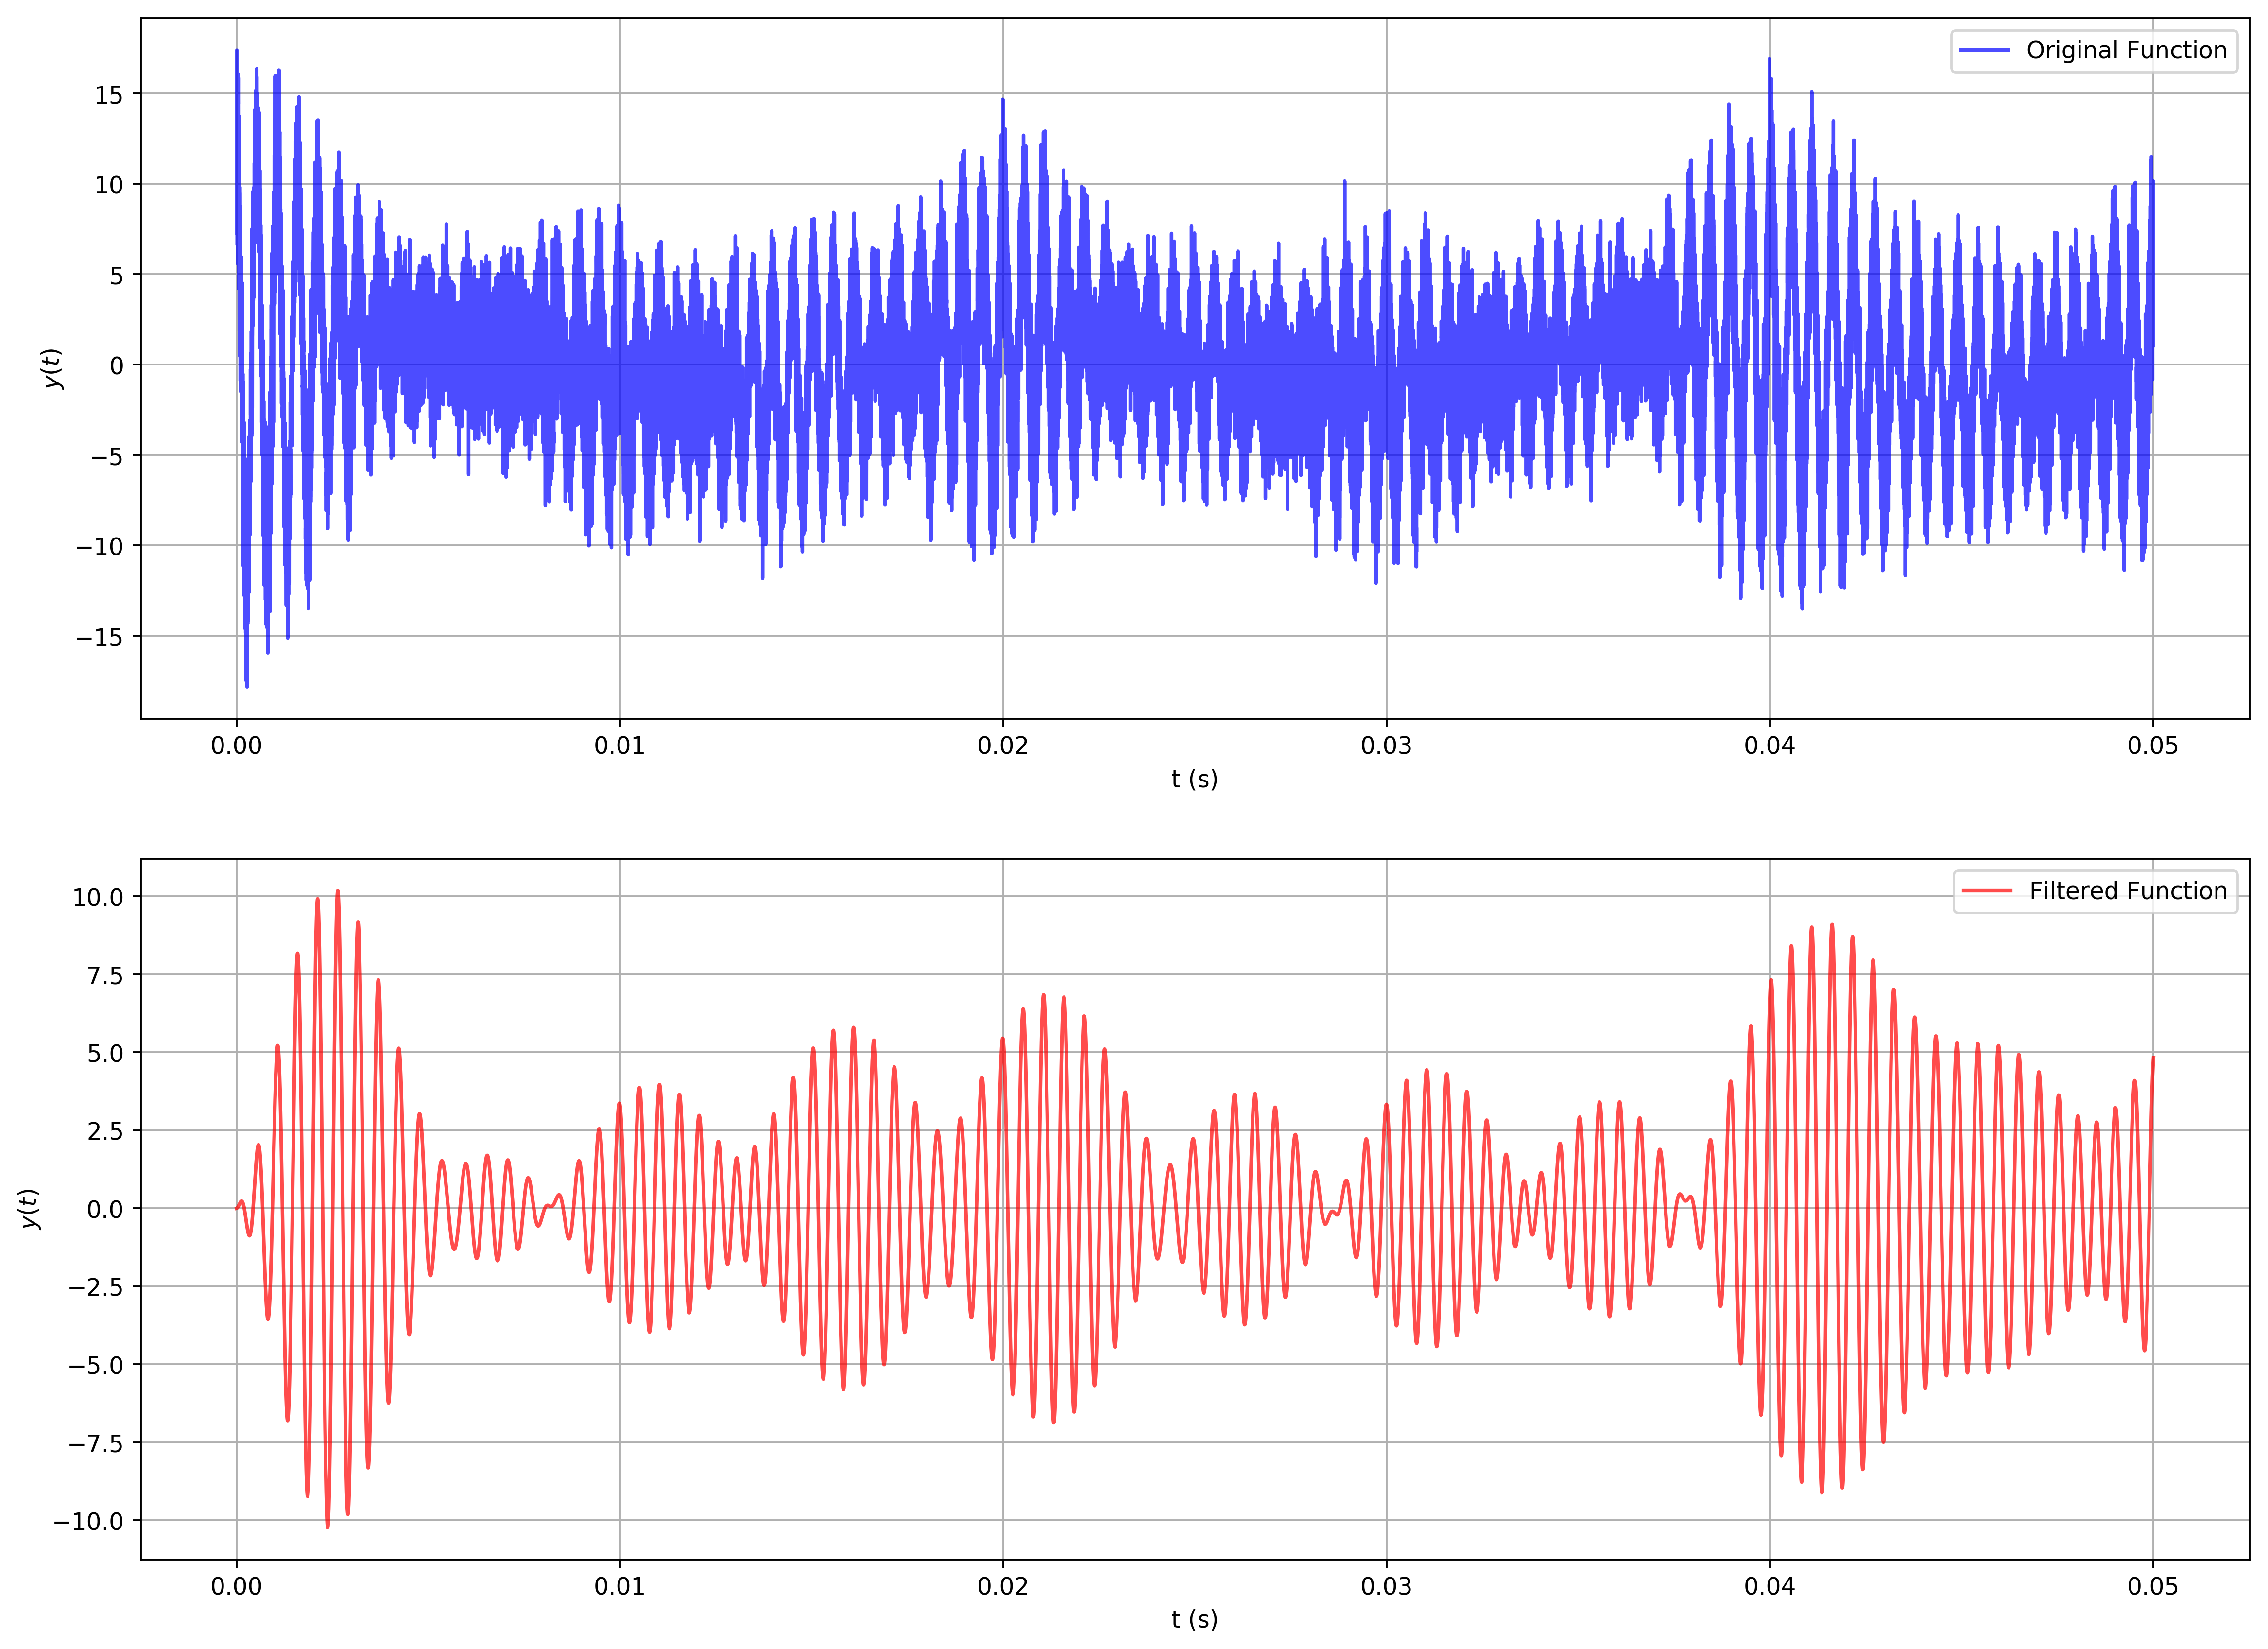

In [10]:
# Pass the input signal through the filter
z_num, z_den = signal.bilinear(num, den, f_samp)
filt  = signal.lfilter(z_num, z_den, sensor_sig)
create_plot([t, t], [(sensor_sig, ), (filt, )],
            ["t (s)", "t (s)"], ["$y(t)$", "$y(t)$"],
            [("Original Function", ), ("Filtered Function", )],
            mode_list=["Norm", "Norm"], num_rows=2)

The results of this filter can be verified in two additional ways. I'll compute the FFT analysis of the filtered signal, and all the results (of significant magnitude) should lie in the sensor's frequency range. In addition to this, I'll visually compare the filtered signal to a signal of 1900 Hz, to visually compare the two's frequency (as amplitude does not matter).

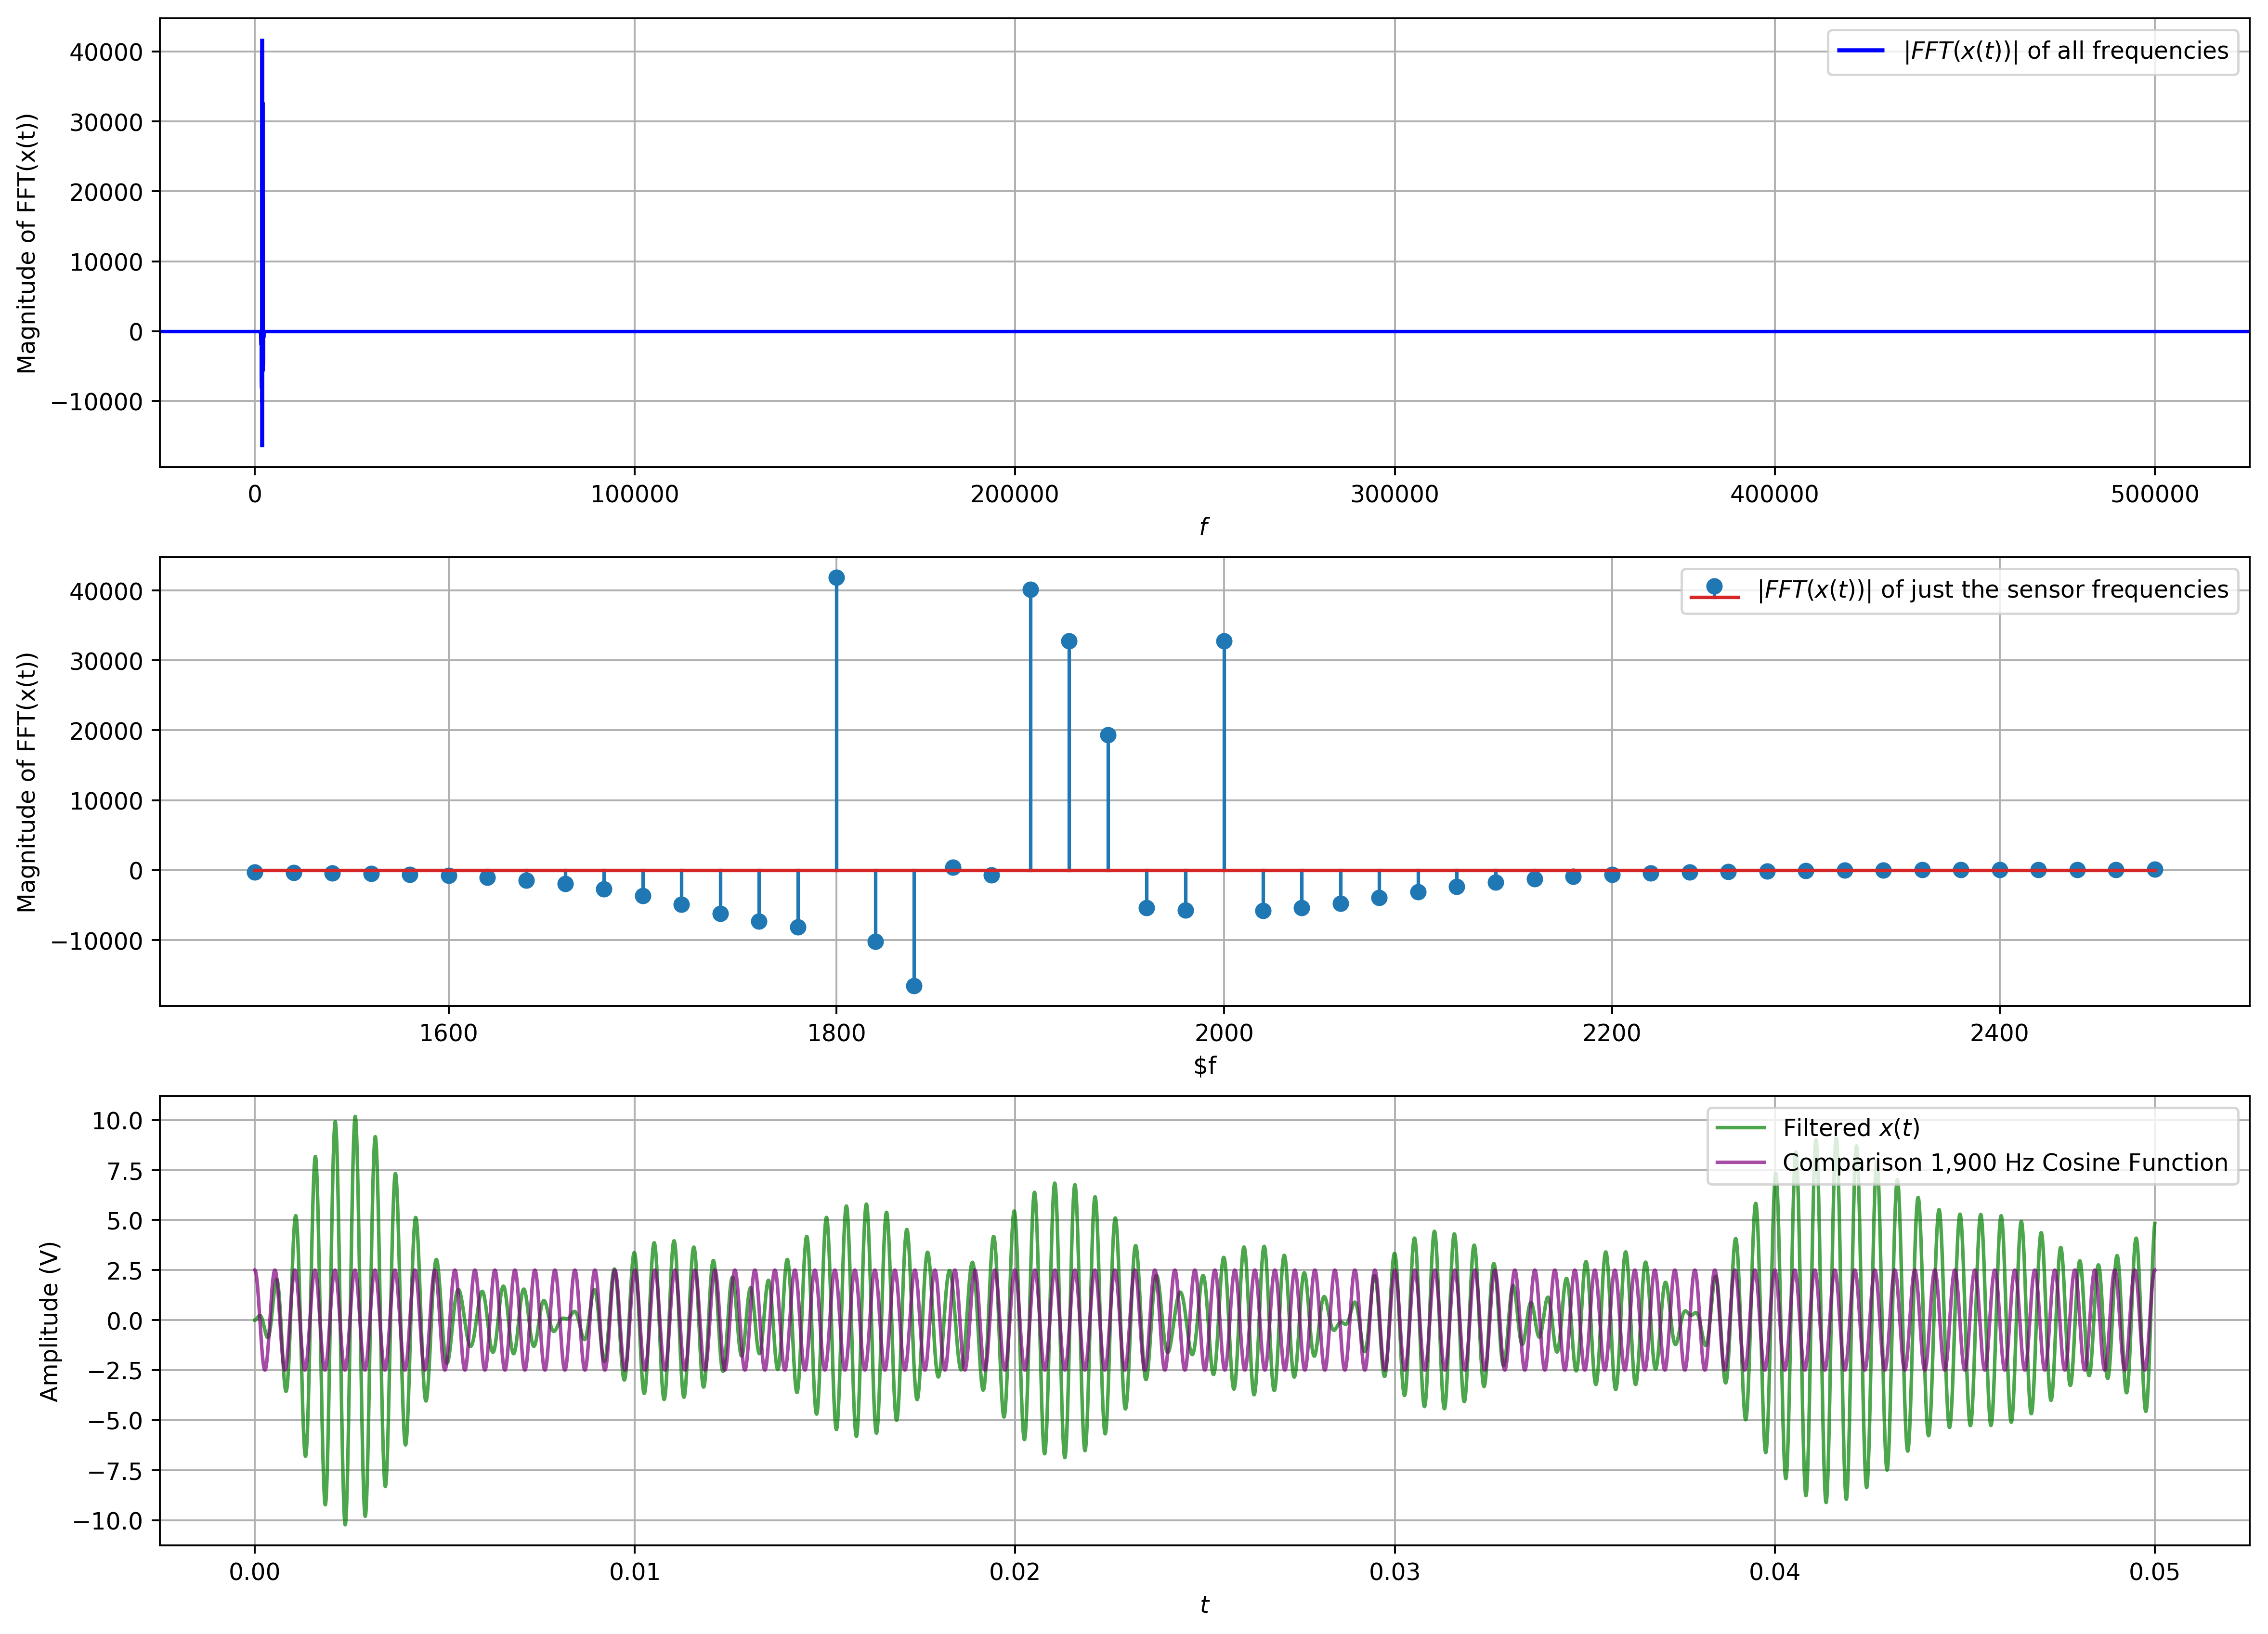

In [12]:
# Compute the FFT of the filtered signal
filt_fft_freq, filt_x_mag, _ = fast_fourier(filt, f_samp)
# Ignore the negative frequencies
filt_fft_freq = filt_fft_freq[:len(filt_fft_freq)//2]
filt_x_mag    = filt_x_mag[:len(filt_x_mag)//2]
sub_freq, sub_mag = subdivide_freq_mag(filt_fft_freq, filt_x_mag, [1500, 2500], mode="Norm")

create_plot([filt_fft_freq, sub_freq, t],
            [(filt_x_mag, ), (sub_mag, ), (filt, 2.5*np.cos(2 * np.pi * 1900 * t))],
            ["$f$", "$f", "$t$"],
            ["Magnitude of FFT(x(t))", "Magnitude of FFT(x(t))", "Amplitude (V)"],
            [("$|FFT(x(t))|$ of all frequencies", ),
             ("$|FFT(x(t))|$ of just the sensor frequencies", ),
             ("Filtered $x(t)$", "Comparison 1,900 Hz Cosine Function")],
            ["Stem", "Stem", "Norm"], 3)

The first two plots show the effect of the filtering on the signal. Beforehand, many frequencies mixed with the sensor's output to create a very messy signal. Clearly, all high-frequencies from other noise sources are almost completely attenuated (as close to zero as possible). The second plot is a zoomed in region from 1,500 Hz to 2,500 Hz. Because the filter isn't perfect, you can see there is some remaining signals outside the sensor's 1,800-2,000 Hz range, but their magnitude is very small.
Finally, the filtered signal is compared to a 'normal' 1,900 Hz cosine function in the final plot, just to visually show how the remaining signal is clearly a very similar frequency (although not exactly 1900, as shown in the fourier series in plot 2).

## Questions

I feel as though there was plenty of labwork on analyzing filters, so I felt adequately prepared for that portion of this final project. However, we never did any labwork on the filter _design_ itself; which meant I felt somewhat confused on where to start. Perhaps have a lab on the `scipy.butter()` function, or any other filtering functions available in the `SciPy` package. Other than that, I felt as though the identification of the sampling frequency was a bit confusing and arbitrary, and could drastically change the results of the Fourier Transform. I ended up going with a relatively high sampling frequency, but when I was testing with lower frequency sample rates my results were drastically different (as expected).

## Conclusion

This final project was very effective at re-applying the skills learned throughout this semester of lab-work. Having a much more open-ended problem meant that a lot of my work had to be '_figured out_' incrementally, rather than being given a step-by-step walkthrough for the tasks required. Overall, I am very happy with the results of my work. The filtered signal is __far__ cleaner than the original input signal, and the bode-plot of the filter fits exactly with the design requirements.